# Analyse Stores in Transactions

In [14]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

stores = pd.read_csv("data/stores.csv")
transactions = pd.read_parquet("data/transactions_train_1.parquet")
transactions_test = pd.read_parquet("data/transactions_test_1.parquet")


In [15]:

print(stores.columns) 

Index(['id', 'opening_date', 'location', 'state', 'urbanization',
       'sco_introduction'],
      dtype='object')


In [ ]:
print("🔹 Erste Zeilen des Datensatzes:")
display(transactions.head())

🔹 Erste Zeilen des Datensatzes:


,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label
0,5bedf771-f016-41a7-ab89-f40e7f6be955,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:00:12,2022-02-02 08:01:02.825563,52.26,6,CREDIT_CARD,NaN,NaN,UNKNOWN
1,21ff1406-dbc4-41a7-8429-836cbf96d853,b0973ffa-ce15-41e0-9de7-1390598e24f2,1,2022-02-02 08:05:06,2022-02-02 08:05:30.565876,1.47,1,CREDIT_CARD,NaN,NaN,UNKNOWN
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,2,2022-02-02 08:07:12,2022-02-02 08:11:29.434607,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL
3,16aa01c9-9678-4c6d-a007-baa3429b9fb8,b0973ffa-ce15-41e0-9de7-1390598e24f2,3,2022-02-02 08:11:45,2022-02-02 08:12:07.881710,3.43,1,CREDIT_CARD,NaN,NaN,UNKNOWN
4,0add22e5-6794-4e95-9d25-a1cd6b6cd083,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:15:15,2022-02-02 08:19:30.611551,441.40,47,CREDIT_CARD,NaN,NaN,UNKNOWN


In [38]:
total_damage = transactions['damage'].sum()
print(f"Gesamtschadenshöhe: {total_damage:.2f} EUR")

Gesamtschadenshöhe: 39345.07 EUR


In [17]:

print(transactions.columns)

Index(['id', 'store_id', 'cash_desk', 'transaction_start', 'transaction_end',
       'total_amount', 'n_lines', 'payment_medium', 'customer_feedback',
       'damage', 'label'],
      dtype='object')


## Join stores und transactions

Schlüsselattributs zur besseren Lesbarkeit umbenennen

In [18]:
stores.rename(columns={"id": "store_id"}, inplace=True)

Join

In [19]:
joined_df = transactions.merge(stores, on="store_id", how="left")

Welche Stores tauchen tatsächlich in Transaktionen auf?

In [20]:
# Alle Store-IDs mit mindestens einer Transaktion
stores_with_tx = transactions["store_id"].unique()

# Anzahl der betroffenen Stores
print(f"Anzahl Stores mit Transaktionen: {len(stores_with_tx)}")


Anzahl Stores mit Transaktionen: 3


Plausibilität prüfen

In [21]:
# Stores ohne Transaktionen herausfiltern
stores_without_tx = stores[~stores["store_id"].isin(stores_with_tx)]

# Anzahl der betroffenen Stores
print(f"Anzahl Stores ohne Transaktionen: {len(stores_without_tx)}")

Anzahl Stores ohne Transaktionen: 15


Betreffende Stores anzeigen

In [22]:
# Auswahl der gewünschten Spalten aus den betroffenen Stores
store_info = stores[stores["store_id"].isin(stores_with_tx)][["store_id", "opening_date", "location"]]

print(store_info)

                               store_id opening_date location
2  b0973ffa-ce15-41e0-9de7-1390598e24f2   2005-06-02   Berlin
4  d3892a9e-8cbc-4237-be9c-211435dc92c0   2003-02-10  München
9  ed996b17-17d6-47e8-9262-d1d02b52cdb4   1994-09-19  München


--> Nur die Stores in München und Berlin tauchen tatsächlich in den Transaktionen auf. Daher sind die übrigen Städte unnötig und können gelöscht werden.

Transactions ohne Store?

In [23]:
fehlende_stores = joined_df["opening_date"].isnull().sum()
print(f"Anzahl Transaktionen ohne zugeordneten Store: {fehlende_stores}")

Anzahl Transaktionen ohne zugeordneten Store: 0


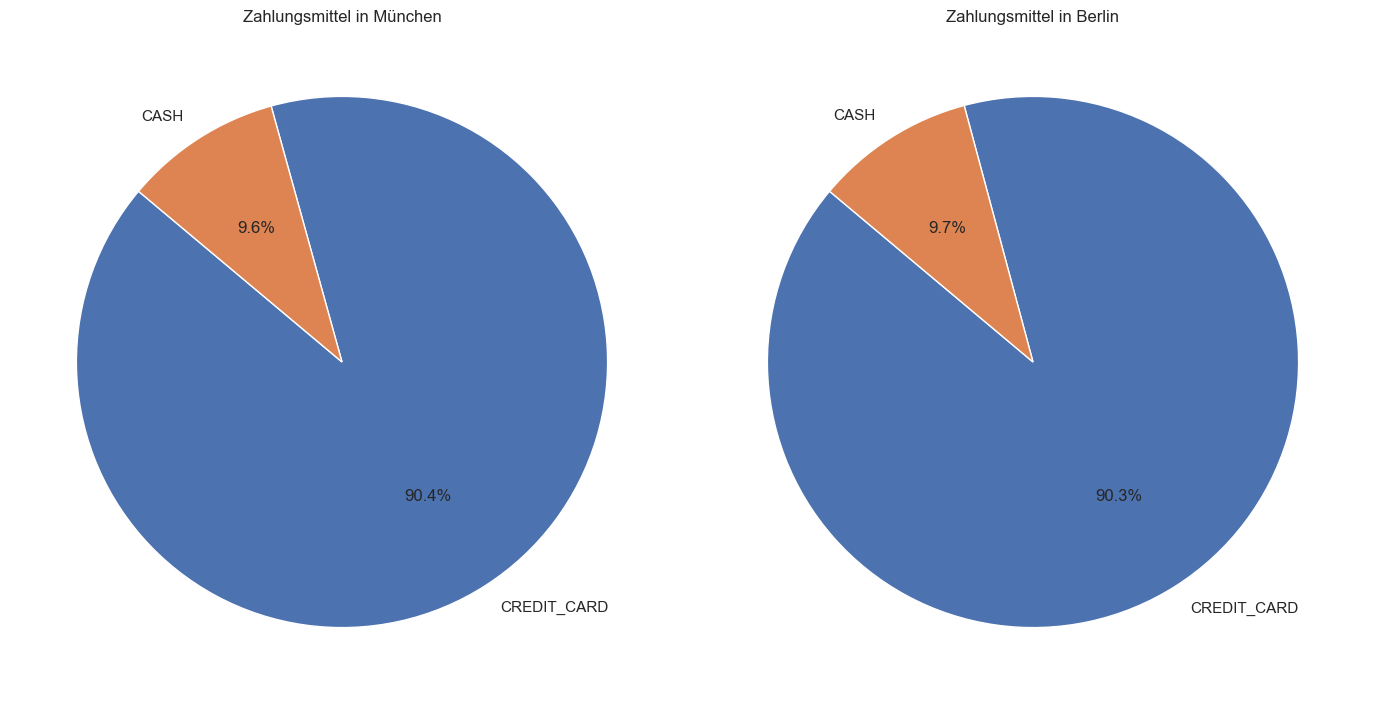

In [24]:
import matplotlib.pyplot as plt
# Schritt 1: Städte filtern – je nach store_id-Struktur anpassen!
joined_df["city"] = joined_df["store_id"].str.extract(r'(^[A-Z]{3})')  # z. B. 'MUC', 'BER'

# Schritt 2: Daten für München und Berlin vorbereiten
payment_munich = joined_df[joined_df["location"] == "München"]["payment_medium"].value_counts()
payment_berlin = joined_df[joined_df["location"] == "Berlin"]["payment_medium"].value_counts()

# Schritt 3: Plot erstellen
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# München
axes[0].pie(payment_munich, labels=payment_munich.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Zahlungsmittel in München")

# Berlin
axes[1].pie(payment_berlin, labels=payment_berlin.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Zahlungsmittel in Berlin")

plt.tight_layout()
plt.show()

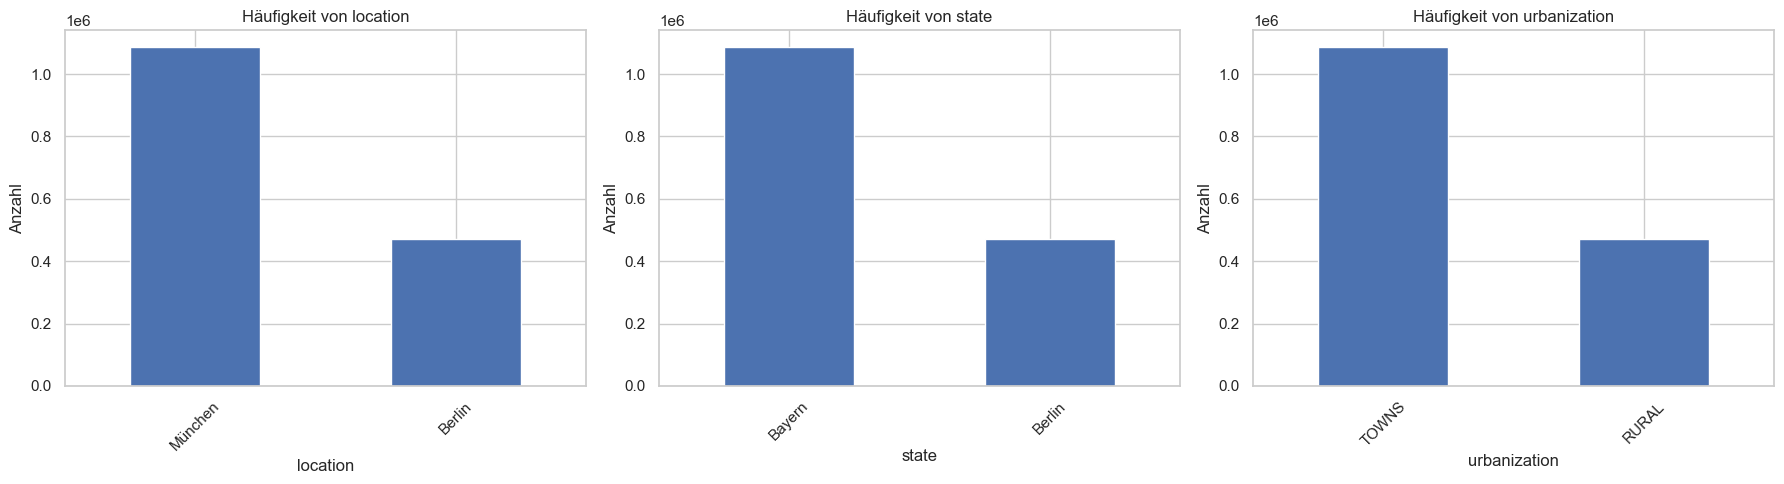

In [25]:
import matplotlib.pyplot as plt

# Liste der Spalten, die du analysieren möchtest
columns_to_plot = ['location', 'state', 'urbanization']

# Setze die Größe der gesamten Figure (3 Unterplots nebeneinander)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Für jede Spalte ein eigenes Balkendiagramm
for ax, col in zip(axes, columns_to_plot):
    joined_df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Häufigkeit von {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Anzahl')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Zusammenhang Betrug & Zahlmethode

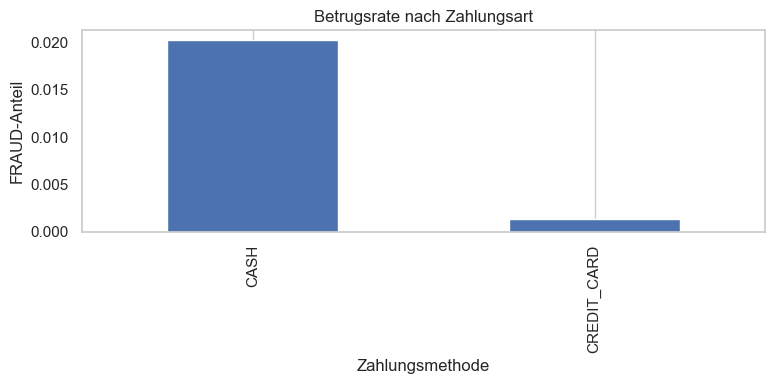

In [27]:
# Nur FRAUD-Fälle zählen
fraud_by_payment = joined_df[joined_df['label'] == 'FRAUD'].groupby('payment_medium').size()
total_by_payment = joined_df.groupby('payment_medium').size()
fraud_rate = (fraud_by_payment / total_by_payment).fillna(0)

# Plot
fraud_rate.plot(kind='bar', title='Betrugsrate nach Zahlungsart', ylabel='FRAUD-Anteil', xlabel='Zahlungsmethode', figsize=(8,4))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


--> Die Betrugsanteil bei Cash-Zahlungen ist deutlich höher als bei Kreditkarte. Es scheint also  Zusammenhang zwischen der Zahlungsart und dem Vorliegen eines Frauds zu geben. Das könnte für die spätere Analyse interessant sein.

Nur gelabelten Datensatz betrachten

In [33]:
joined_clean = joined_df[joined_df['label'] != 'UNKNOWN']

Zusammenhang Label & Amount

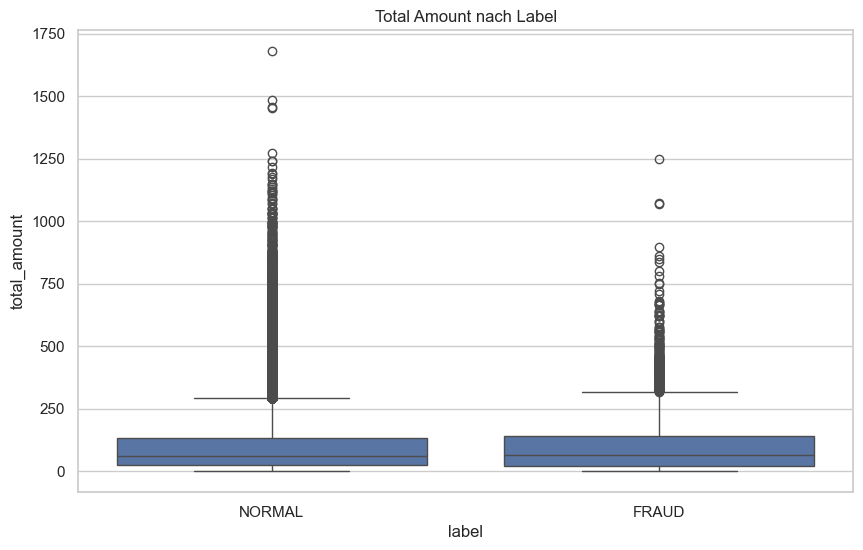

In [34]:
sns.boxplot(data=joined_clean, x='label', y='total_amount')
plt.title('Total Amount nach Label')
plt.grid(True, axis='y')
plt.show()


In [35]:
# Wochentag hinzufügen (0 = Montag, 6 = Sonntag)
joined_clean['weekday'] = joined_clean['transaction_start'].dt.dayofweek
# Alternativ: Namen der Wochentage (für lesbare Plots)
joined_clean['weekday_name'] = joined_clean['transaction_start'].dt.day_name()


C:\Users\sofie\AppData\Local\Temp\ipykernel_48248\43667442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_clean['weekday'] = joined_clean['transaction_start'].dt.dayofweek
C:\Users\sofie\AppData\Local\Temp\ipykernel_48248\43667442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_clean['weekday_name'] = joined_clean['transaction_start'].dt.day_name()


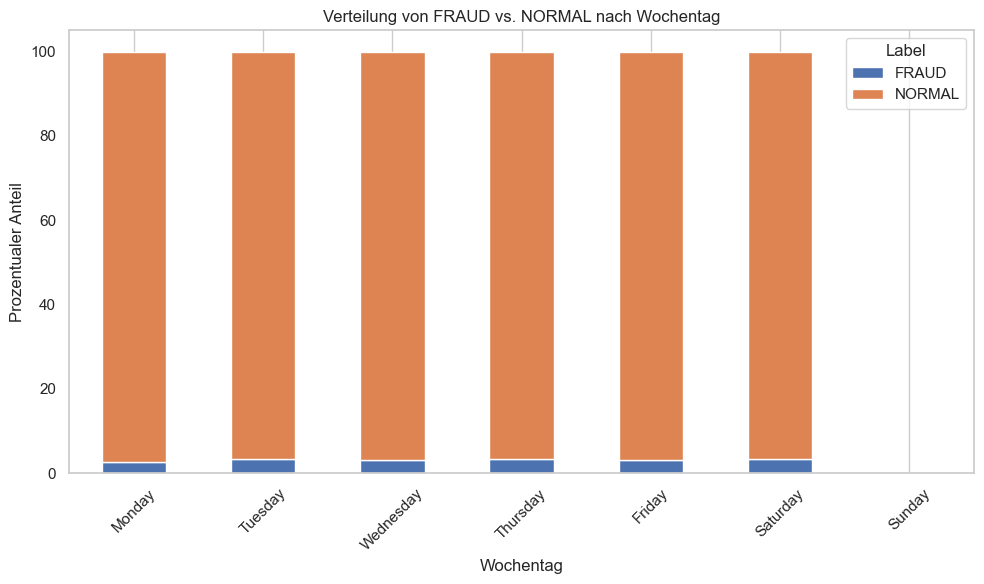

In [37]:
# Kreuztabelle: Anteil FRAUD/NORMAL je Wochentag (prozentual)
label_dist = pd.crosstab(joined_clean['weekday_name'], joined_clean['label'], normalize='index') * 100

# Wochentage in sinnvoller Reihenfolge sortieren
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
label_dist = label_dist.reindex(weekday_order)

# Plot
label_dist.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Verteilung von FRAUD vs. NORMAL nach Wochentag')
plt.ylabel('Prozentualer Anteil')
plt.xlabel('Wochentag')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
